<a id='logbook'></a>
# Ship power prediction
Analysis and development of a model to predict ship power.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [63]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import sympy as sp

import pandas as pd
import numpy as np

# Unmark for publish quality plots
#if os.name == 'nt':
#    plt.style.use('paper.mplstyle')  # Windows

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import r2_score
from scipy.integrate import solve_ivp
import seaborn as sns

from copy import deepcopy
import sys
sys.path.append('../../')
from src.notebook_to_latex import Equation, equation_dict
#from src import equations,symbols
import reports.paper_writing
from src.df_to_latex import LateXTable
import src.data.load as load
from src.data.transform import transform
from src.visualization.visualize import plotable_dataframe

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import xgboost

## Examples:


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')

from IPython.display import HTML, Markdown, Image
from src.df_to_latex import LateXTable

# Abstract
Full-scale measurement data of ship’s propulsion power is analyzed. Various statistics and machine learning models are fitted to predict the propulsion power based on features about the ship operational condition and data about the encountered metocean environments.  

# Introduction

<a id='fig_rolldecay_example>'></a>

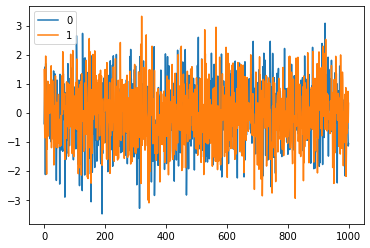

In [4]:
fig,ax=plt.subplots()
df = pd.DataFrame(data=np.random.normal(size=(1000,2)))
df.plot(ax=ax);

The oscillating motion can be described by a spring-mass-damper system as seen in Fig.[(below)](#fig_spring_mass_damper).

This system can me described as the following equation [(below)](#eq_equation1):

<a id="eq_equation1"></a>

In [5]:
eq = r'$E=m \dot c^2 $'
Equation(eq, label='equation1')

<src.notebook_to_latex.Equation object>

In [6]:
A,r = sp.symbols('A r')
eq = sp.Eq(A,
          r**2*sp.pi)
Equation(eq, label='equation2')

<src.notebook_to_latex.Equation object>

# Data
The data used in this study is described in Tab.[(below)](#fig_data_description).

<a id="fig_data_description"></a>

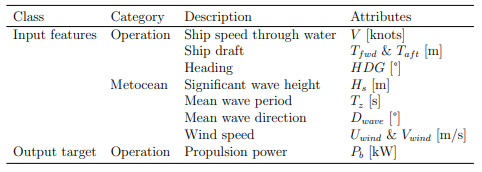

In [7]:
Image('../figures/data_description.PNG')

## Exploratory data analysis
The ship speed $V$, ship draughts $T_{aft}$ and $T_{fwd}$ were all negative in the raw data file. This was imidiatelly corrected, to be more in line with what would be expected from a more general sign convention.

In [8]:
raw_data = load.raw()

In [9]:
display(raw_data.head())
display(raw_data.describe())
display(raw_data.dtypes)

,Power,V,T_fwd,T_aft,HDG,Hs,Tz,D_wave,U_wind,V_wind
0,4096.859211,23.359333,10.25,10.2,225.120423,0.336355,4.113880,58.287071,-0.251960,0.598855
1,4062.904838,23.351923,10.25,10.2,225.121609,0.334025,4.107303,61.219389,-0.205543,0.537524
2,4105.640943,23.304333,10.25,10.2,213.803859,0.331768,4.100033,64.378446,-0.167395,0.480271
3,4156.401020,23.293167,10.25,10.2,225.124531,0.328743,4.084423,69.095584,-0.153352,0.410798
4,4147.498244,23.287000,10.25,10.2,225.125682,0.326883,4.072262,73.970302,-0.125637,0.360612


,Power,V,T_fwd,T_aft,HDG,Hs,Tz,D_wave,U_wind,V_wind
count,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000
mean,3188.935287,24.278879,11.182685,11.093998,254.571157,1.666358,7.462152,204.735041,2.035780,0.747150
std,1332.289539,1.001131,0.715500,0.701950,70.481649,0.813212,1.955307,80.514470,4.931660,4.261370
min,1000.000000,22.436267,10.250000,10.160000,0.000000,0.158431,2.233657,2.680181,-11.236499,-14.531855
25%,1815.723938,23.454343,10.700000,10.600000,245.028127,1.153389,6.396379,169.396098,-0.985087,-2.065295
50%,3173.939254,24.132437,11.000000,10.800000,270.018724,1.540236,7.497403,205.961881,2.740314,0.088762
75%,4385.159249,24.897164,11.700000,11.600000,292.405334,2.160576,8.980331,268.427660,5.574664,3.568319
max,5974.050320,27.955649,12.400000,12.200000,347.212496,4.330742,11.513423,358.097469,13.623467,12.415640


Power     float64
V         float64
T_fwd     float64
T_aft     float64
HDG       float64
Hs        float64
Tz        float64
D_wave    float64
U_wind    float64
V_wind    float64
dtype: object

Fig.[(below)](#fig_heat_map_raw_data) shows a heat map of the absolute linear correlation coefficient between all of the features in the raw data. It can be seen that $T_{aft}$ and $T_{fwd}$ have the highest correlation with the $Power$. It can also be seen that the correlation between $T_{aft}$ and $T_{fwd}$ is also very high (approximately 1) implying a very high multicollinearity which is generally something that should be avoided in regression problems. These two features are instead replaced with the two features: mean draught $T$ and $trim$. The correspondig heat map with the new features is shown in Fig.[(below)](#fig_heat_map_data). The mean draught $T$ now seems to be a very important feature in this regression as it has the highest linear correlation with the $Power$.

<a id="fig_heat_map_raw_data"></a>

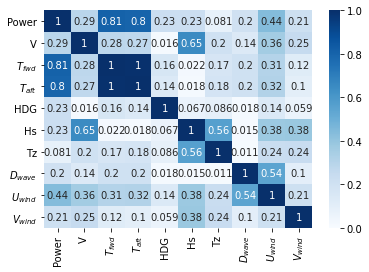

In [10]:
corr = plotable_dataframe(raw_data.corr().abs())

ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True)
fig = ax.get_figure()

<a id="fig_heat_map_data"></a>

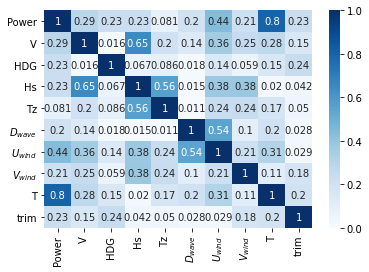

In [11]:
data = transform(raw_data=raw_data)

corr = plotable_dataframe(data.corr().abs())

ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True)
fig = ax.get_figure()

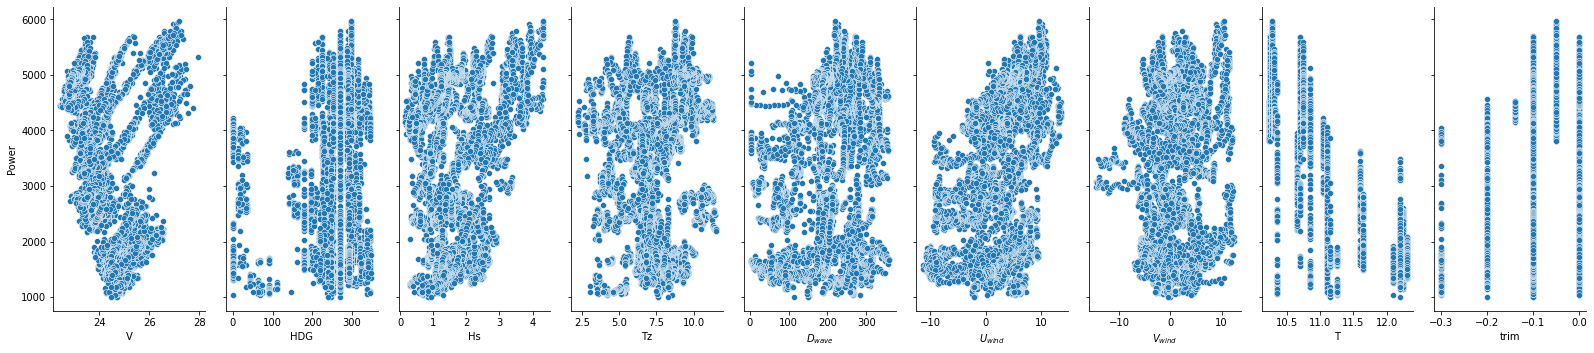

In [12]:
data_plot = plotable_dataframe(data)
x_vars = list(data_plot.columns)
x_vars.remove('Power')

g = sns.PairGrid(data_plot,y_vars='Power', x_vars=x_vars, height=5, aspect=0.5)
g.map_offdiag(sns.scatterplot);

(-1.0, 1.0)

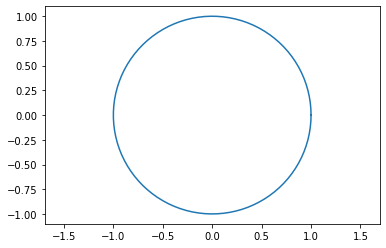

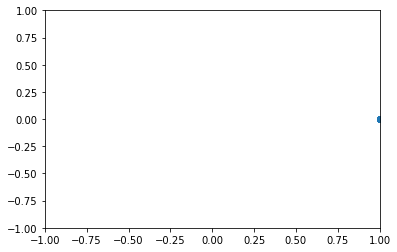

In [13]:
from scipy.spatial.transform import Rotation as R

psi = np.linspace(0,360,100)
r = R.from_euler('z', psi, degrees=True)
coords = r.apply([1,0,0])

fig,ax = plt.subplots()
ax.plot(coords[:,0], coords[:,1],'-');
ax.axis('equal');

r2 = r.inv()
coords = r2.apply(coords)

fig,ax = plt.subplots()
ax.plot(coords[:,0], coords[:,1],'o');
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)




In [14]:

r = R.from_euler('z', data['HDG'], degrees=True)
r2 = r.inv()
#r2 = r

In [15]:
from sympy.vector import CoordSys3D
W = CoordSys3D(name='W')
psi = sp.symbols('psi')
B = W.orient_new_axis('B', psi, W.k)
W.rotation_matrix(B)

Matrix([
[cos(psi), -sin(psi), 0],
[sin(psi),  cos(psi), 0],
[       0,         0, 1]])

In [16]:
## Wind
data['W_wind'] = 0
data[['u_wind','v_wind']] = r2.apply(data[['U_wind','V_wind','W_wind']])[:,0:2]
data.drop(columns=['W_wind'], inplace=True)


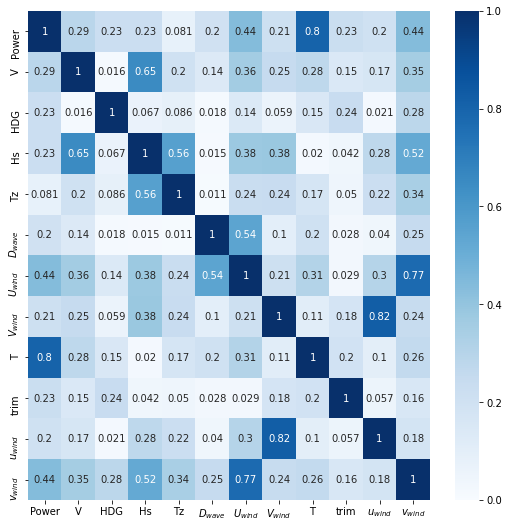

In [17]:
corr = plotable_dataframe(data.corr().abs())
fig,ax = plt.subplots()
fig.set_size_inches(9,9)
ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True, ax=ax)


# Regression

In [18]:
X = data.copy()
y = X.pop('Power')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': np.arange(3, 20)}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
             scoring='r2')

In [36]:
grid_search.best_params_

{'max_depth': 18}

In [37]:
grid_search.cv_results_['mean_test_score']

array([0.81847755, 0.8681929 , 0.90702782, 0.93431431, 0.95696408,
       0.97057551, 0.97706935, 0.9808534 , 0.98429259, 0.98450664,
       0.98478428, 0.98524743, 0.9856574 , 0.98510345, 0.98496601,
       0.98579513, 0.98558388])

<AxesSubplot:xlabel='param_max_depth'>

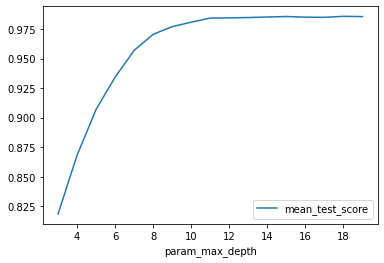

In [45]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.plot(x='param_max_depth', y='mean_test_score', )

In [48]:
model = DecisionTreeRegressor(random_state=42, max_depth=11)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9836991329343434

In [52]:
feature_importances = pd.Series(data=model.feature_importances_,
                                index=X_train.columns)

<AxesSubplot:>

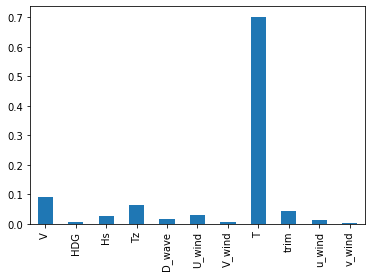

In [53]:
feature_importances.plot(kind='bar')

In [60]:
linear_regression = LinearRegression()
polynomial_features = PolynomialFeatures(degree=3)
standard_scaler = StandardScaler()

steps = [
    ('scaler', standard_scaler),
    ('polynomial_features', polynomial_features),
    ('linear_regression', linear_regression),
]

model_polynomial = Pipeline(steps=steps)

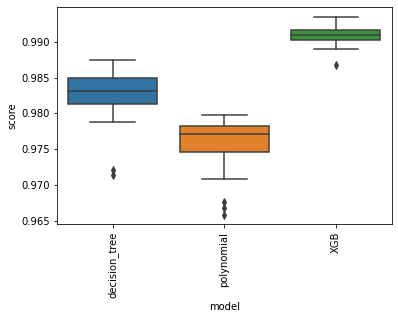

In [64]:
models = {
    'decision_tree': DecisionTreeRegressor(random_state=42, max_depth=11),
    'polynomial':model_polynomial,
    'XGB' : xgboost.XGBRegressor(),
}

cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)
scores = {}
for model_name, model in models.items():
    scores[model_name] = cross_val_score(estimator=model, X=X_train, y=y_train, 
                                         scoring='r2', cv=cv, n_jobs=-1)
    
df_cross_validation = pd.DataFrame()

for model_name, model in models.items():

    scores_ = cross_val_score(estimator=model, X=X_train, y=y_train, scoring='r2', cv=cv, n_jobs=-1)
    validations = np.arange(0,len(scores_))
    df_=pd.DataFrame()
    df_['validation']=validations
    df_['score']=scores_
    df_['model']=model_name
    df_cross_validation=df_cross_validation.append(df_, ignore_index=True)

df_scores = pd.DataFrame(scores)

ax = sns.boxplot(x='model', y='score', data=df_cross_validation)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

# Conclusions
  




# References
<div class="cite2c-biblio"></div>